# Density Estimation using Mask Autoregressive Flow (MAF)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import sys

from data.visu_density import plot_heatmap_2d
from data.toy_data import generate_2d_data
from data.plot_samples import plot_samples_2d
from utils.train_utils import shuffle_split, sanity_check, train_density_estimation
from normalizingflows.flow_catalog import Made

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1234)

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


In [2]:
# parameters
dataset_size = 2000
batch_size = 800
dataset = 'swissroll'
layers = 5
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(15e3)
shape = [64, 64]

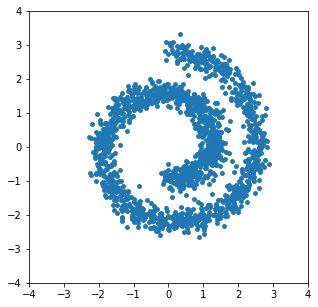

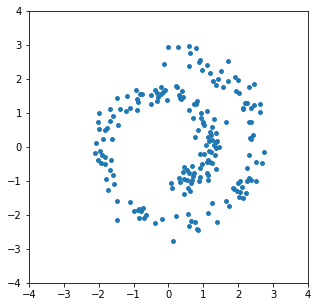

In [3]:
# generate toy data
plot = True
save_plots = False

train_split = 0.8
val_split = 0.1
samples, _ = generate_2d_data(dataset, batch_size=dataset_size)
train_data, val_data, test_data = shuffle_split(samples, train_split, val_split)

if plot:
    plot_samples_2d(train_data)
    plot_samples_2d(val_data)
if save_plots:
    plt.savefig(dataset + "/" + dataset + '.png', format="png")

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
batched_train_data = train_dataset.batch(batch_size)

In [4]:
# base distribution: one normal distribution for each dimension
base_dist = tfd.Normal(loc=0., scale=1.)

### Create MAF flow

In [5]:
bijectors = []

for i in range(0, layers):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn = Made(params=2, hidden_units=shape, activation="relu")))
    bijectors.append(tfb.Permute(permutation=[1, 0])) # Permutation improves denstiy estimation results
    
bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_maf')


maf = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector,
    event_shape=[2]
)

# caution: weight vectors are seen as one trainable variable
samples = maf.sample() # initialize

In [6]:
n_trainable_variables = 0
for weights in maf.trainable_variables:
    n_trainable_variables = n_trainable_variables + np.prod(weights.shape)
print(n_trainable_variables)

23060


In [7]:
# learning rate scheduling
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [8]:
# initialize checkpoints
checkpoint_directory = "toy_data/{}/tmp_{}_{}_{}".format(dataset, layers, shape[0], shape[1])
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=maf)

0, train_loss: 4.045168399810791, val_loss: 3.834855556488037
100, train_loss: 3.0379815101623535, val_loss: 3.0910065174102783
200, train_loss: 2.9486193656921387, val_loss: 3.0079894065856934
300, train_loss: 2.8900015354156494, val_loss: 2.9653894901275635
400, train_loss: 2.8592844009399414, val_loss: 2.974414110183716
500, train_loss: 2.8129308223724365, val_loss: 2.959399938583374
600, train_loss: 3.0365149974823, val_loss: 3.0246431827545166
700, train_loss: 2.8748579025268555, val_loss: 2.9012789726257324
800, train_loss: 2.8258402347564697, val_loss: 2.8314783573150635
900, train_loss: 2.802971839904785, val_loss: 2.835820198059082
1000, train_loss: 2.795206069946289, val_loss: 2.8219950199127197
1100, train_loss: 2.779498338699341, val_loss: 2.851982831954956
1200, train_loss: 2.776468276977539, val_loss: 2.8416380882263184
1300, train_loss: 2.758451223373413, val_loss: 2.8691723346710205
1400, train_loss: 2.739064931869507, val_loss: 2.880183458328247
1500, train_loss: 2.728

/nfs/homedirs/rinder/project-8/data/visu_density.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


10100, train_loss: 2.529327630996704, val_loss: 2.975660800933838
10200, train_loss: 2.5347740650177, val_loss: 3.0583035945892334
10300, train_loss: 2.5363380908966064, val_loss: 2.9187240600585938
10400, train_loss: 2.5330312252044678, val_loss: 2.980992078781128
10500, train_loss: 2.530933380126953, val_loss: 3.0019969940185547
10600, train_loss: 2.529148817062378, val_loss: 2.988971471786499
10700, train_loss: 2.5598201751708984, val_loss: 2.9152822494506836
10800, train_loss: 2.5405948162078857, val_loss: 3.0004642009735107
10900, train_loss: 2.5378005504608154, val_loss: 3.0272765159606934
11000, train_loss: 2.5369346141815186, val_loss: 3.0673274993896484
11100, train_loss: 2.5339574813842773, val_loss: 3.0603528022766113
11200, train_loss: 2.534890651702881, val_loss: 3.0610451698303223
11300, train_loss: 2.533639907836914, val_loss: 3.06790828704834
11400, train_loss: 2.582023859024048, val_loss: 2.9195754528045654
11500, train_loss: 2.5783562660217285, val_loss: 2.92290782928

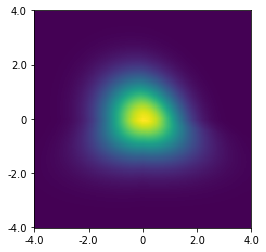

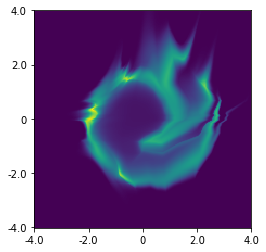

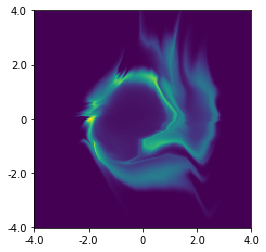

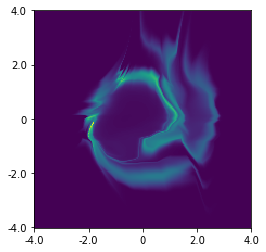

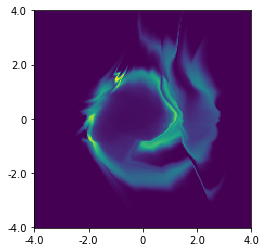

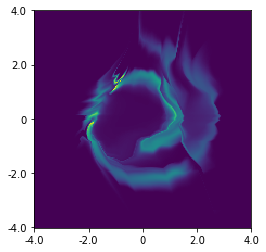

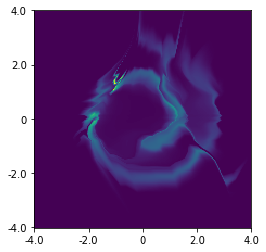

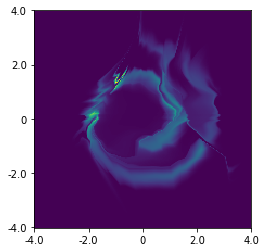

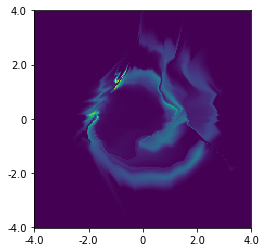

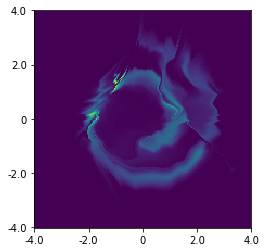

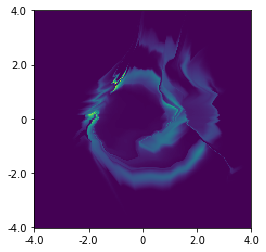

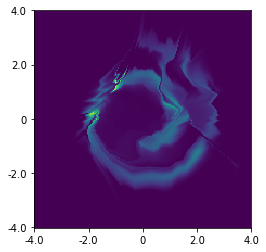

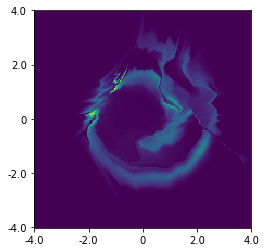

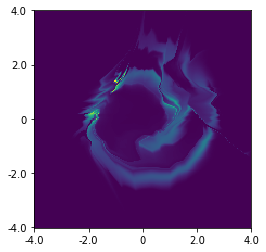

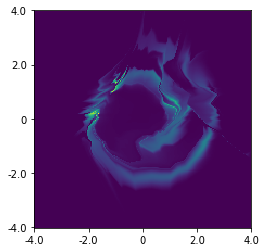

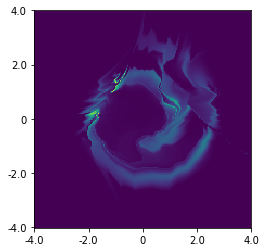

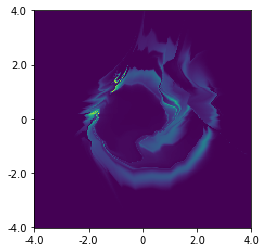

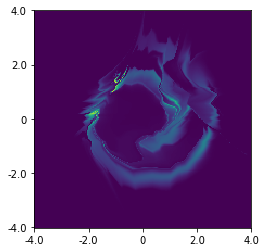

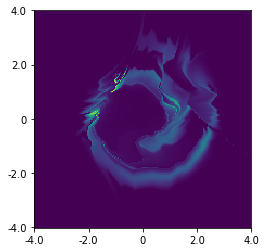

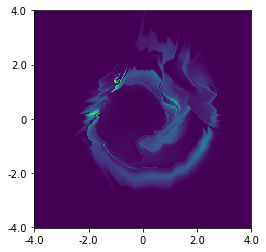

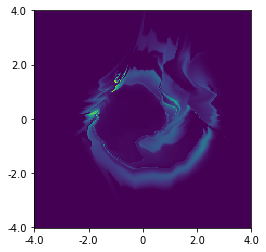

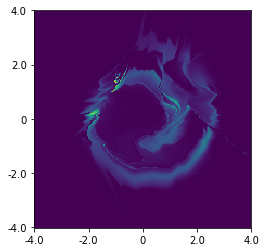

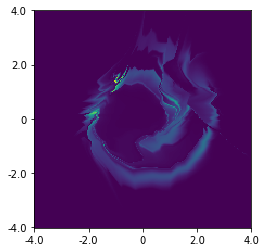

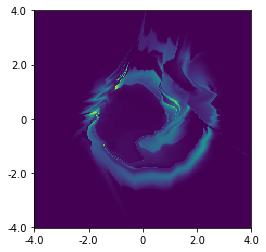

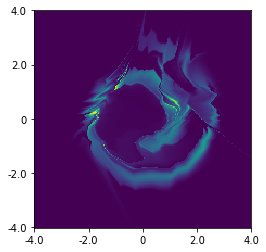

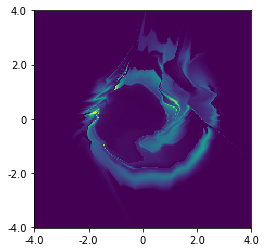

In [9]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 10000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(maf, opt, batch)

    if i % int(100) == 0:
        val_loss = -tf.reduce_mean(maf.log_prob(val_data))
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i
            checkpoint.write(file_prefix=checkpoint_prefix)  # overwrite best val model

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(500) == 0:
        # plot heatmap
        plot_heatmap_2d(maf, -4.0, 4.0, -4.0, 4.0, mesh_count=200)

train_time = time.time() - t_start

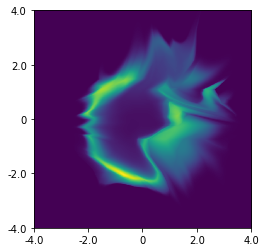

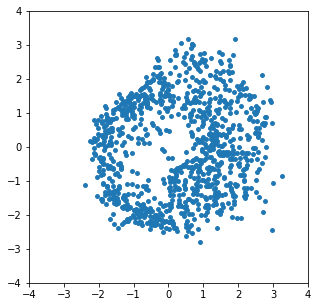

In [12]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = -tf.reduce_mean(maf.log_prob(test_data))
test_time = time.time() - t_start

# save density estimation of best model
save_dir = "toy_data/{}_density_{}_{}_{}_{}_{}".format(dataset, exp_number, batch_size, layers, shape, min_val_epoch)
plot_heatmap_2d(maf, -4.0, 4.0, -4.0, 4.0, name=save_dir)

# save sampling of best model
save_dir = "toy_data/{}_sampling_{}_{}_{}_{}_{}".format(dataset, exp_number, batch_size, layers, shape, min_val_epoch)
plot_samples_2d(maf.sample(1000), name=save_dir)

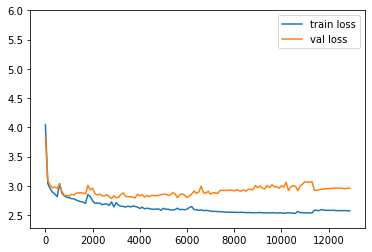

In [10]:
# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.ylim((min_val_loss-0.5).numpy(), 6)
plt.legend()

In [11]:
# delete checkpoints
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)

### Sanity Check
Ensure that the integral of the pdf sums up to 1.

In [ ]:
integral = sanity_check(maf, xmin=-4.0, xmax=4.0, ymin=-4.0, ymax=4.0, mesh_count=500)
print(integral)